In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from loader import get_train_loader

In [5]:
class Autoencoder16(nn.Module):
    def __init__(self):
        super(Autoencoder16, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=2, padding=0),
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ConvTranspose2d(16, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
#         print(latent_code.shape)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [16]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder16().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [8]:
train_loader, val_loader = get_train_loader("../deepfashion/index.p", batch_size=64, resize_size=32)

In [17]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

train_loss = []
val_loss = []
reconstructed_pictures = []

import time
num_epochs = 100 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    i = 0
    for X_batch, y_batch in train_loader:
        i += 1
        # train on batch
        X_batch_0 = torch.FloatTensor(X_batch[:, 0])
        X_batch_0 = Variable(X_batch_0).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_0)
        loss = criterion(output_img, X_batch_0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
        
        X_batch_1 = torch.FloatTensor(X_batch[:, 1])
        X_batch_1 = Variable(X_batch_1).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_1)
        loss = criterion(output_img, X_batch_1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
#         print(i, ":", loss.data.cpu().numpy()[0], end=", ")

    # And a full pass over the validation data:
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        X_batch_0 = Variable(X_batch[:, 0]).cuda()
        output_img, _ = autoencoder(X_batch_0)
        val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
        X_batch_1 = Variable(X_batch[:, 1]).cuda()
        output_img, _ = autoencoder(X_batch_1)
        val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])
#         val_loss.append(criterion(output_img, X_batch).data.numpy())
#     if epoch % 16 == 0:
#         X_batch = Variable(torch.FloatTensor(np.array([X_val[247]]))).cuda()
#         output_img, _ = autoencoder(X_batch)
#         # reconstructed_pictures.append(output_img.cpu().data.numpy()[0])
#         reconstructed_pictures.append(output_img.data.numpy())
    # Then we print the results for this epoch:
    print 
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-2 * len(train_loader):])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-2 * len(val_loader):])))

Epoch 1 of 100 took 67.844s
  training loss (in-iteration): 	0.021641
  validation loss: 			0.008521
Epoch 2 of 100 took 64.264s
  training loss (in-iteration): 	0.003836
  validation loss: 			0.003772
Epoch 3 of 100 took 64.740s
  training loss (in-iteration): 	0.002701
  validation loss: 			0.004170
Epoch 4 of 100 took 62.875s
  training loss (in-iteration): 	0.002374
  validation loss: 			0.004026
Epoch 5 of 100 took 63.957s
  training loss (in-iteration): 	0.002186
  validation loss: 			0.004379
Epoch 6 of 100 took 63.730s
  training loss (in-iteration): 	0.002058
  validation loss: 			0.003739
Epoch 7 of 100 took 63.874s
  training loss (in-iteration): 	0.001964
  validation loss: 			0.003051
Epoch 8 of 100 took 62.566s
  training loss (in-iteration): 	0.001891
  validation loss: 			0.002908
Epoch 9 of 100 took 64.254s
  training loss (in-iteration): 	0.001828
  validation loss: 			0.002771
Epoch 10 of 100 took 62.701s
  training loss (in-iteration): 	0.001775
  validation loss: 	

Epoch 82 of 100 took 64.890s
  training loss (in-iteration): 	0.000955
  validation loss: 			0.001022
Epoch 83 of 100 took 62.874s
  training loss (in-iteration): 	0.000953
  validation loss: 			0.001026
Epoch 84 of 100 took 64.626s
  training loss (in-iteration): 	0.000951
  validation loss: 			0.001019
Epoch 85 of 100 took 62.404s
  training loss (in-iteration): 	0.000948
  validation loss: 			0.001024
Epoch 86 of 100 took 62.510s
  training loss (in-iteration): 	0.000946
  validation loss: 			0.001005
Epoch 87 of 100 took 63.567s
  training loss (in-iteration): 	0.000943
  validation loss: 			0.001006
Epoch 88 of 100 took 62.239s
  training loss (in-iteration): 	0.000941
  validation loss: 			0.000997
Epoch 89 of 100 took 62.327s
  training loss (in-iteration): 	0.000939
  validation loss: 			0.000986
Epoch 90 of 100 took 62.647s
  training loss (in-iteration): 	0.000936
  validation loss: 			0.000985
Epoch 91 of 100 took 62.128s
  training loss (in-iteration): 	0.000934
  validatio

In [22]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    scale_const = 1.2
    plt.figure(figsize=(3 / scale_const * n_col, 3.4 / scale_const * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].numpy().transpose(1,2,0), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [19]:
autoencoder.train(False)

Autoencoder16(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (5

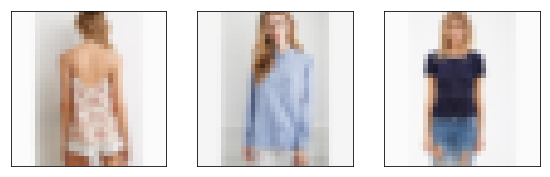

In [24]:
plot_gallery(X_batch[:3, 1], 16, 16, n_row=1, n_col=3)

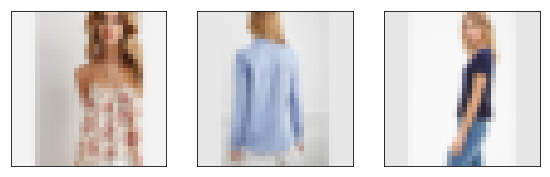

In [23]:
plot_gallery(X_batch[:3, 0], 16, 16, n_row=1, n_col=3)

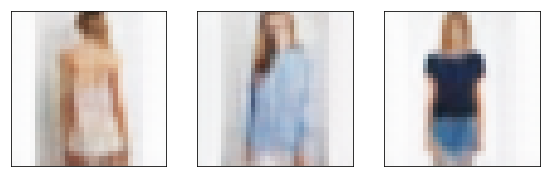

In [25]:
plot_gallery(autoencoder(Variable(X_batch[:3, 1]).cuda())[0].cpu().data, 16, 16, n_row=1, n_col=3)

In [26]:
torch.save(autoencoder, "autoencoder.people.16.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Autoencoder16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Train stickmans

In [10]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder16().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [12]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

train_loss = []
val_loss = []
reconstructed_pictures = []

import time
num_epochs = 100 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    i = 0
    for X_batch, y_batch in train_loader:
        i += 1
        # train on batch
        X_batch_0 = torch.FloatTensor(y_batch[:, 0])
        X_batch_0 = Variable(X_batch_0).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_0)
        loss = criterion(output_img, X_batch_0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
        
        X_batch_1 = torch.FloatTensor(y_batch[:, 1])
        X_batch_1 = Variable(X_batch_1).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_1)
        loss = criterion(output_img, X_batch_1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
#         print(i, ":", loss.data.cpu().numpy()[0], end=", ")

    # And a full pass over the validation data:
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        X_batch_0 = Variable(y_batch[:, 0]).cuda()
        output_img, _ = autoencoder(X_batch_0)
        val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
        X_batch_1 = Variable(y_batch[:, 1]).cuda()
        output_img, _ = autoencoder(X_batch_1)
        val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])
#         val_loss.append(criterion(output_img, X_batch).data.numpy())
#     if epoch % 16 == 0:
#         X_batch = Variable(torch.FloatTensor(np.array([X_val[247]]))).cuda()
#         output_img, _ = autoencoder(X_batch)
#         # reconstructed_pictures.append(output_img.cpu().data.numpy()[0])
#         reconstructed_pictures.append(output_img.data.numpy())
    # Then we print the results for this epoch:
    print 
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-2 * len(train_loader):])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-2 * len(val_loader):])))

Epoch 1 of 100 took 59.144s
  training loss (in-iteration): 	0.005758
  validation loss: 			0.004257
Epoch 2 of 100 took 59.719s
  training loss (in-iteration): 	0.002830
  validation loss: 			0.002145
Epoch 3 of 100 took 60.002s
  training loss (in-iteration): 	0.001663
  validation loss: 			0.001522
Epoch 4 of 100 took 59.701s
  training loss (in-iteration): 	0.001251
  validation loss: 			0.001207
Epoch 5 of 100 took 58.549s
  training loss (in-iteration): 	0.001062
  validation loss: 			0.001050
Epoch 6 of 100 took 59.574s
  training loss (in-iteration): 	0.000949
  validation loss: 			0.000952
Epoch 7 of 100 took 58.296s
  training loss (in-iteration): 	0.000873
  validation loss: 			0.000880
Epoch 8 of 100 took 59.160s
  training loss (in-iteration): 	0.000813
  validation loss: 			0.000836
Epoch 9 of 100 took 58.278s
  training loss (in-iteration): 	0.000766
  validation loss: 			0.000794
Epoch 10 of 100 took 58.561s
  training loss (in-iteration): 	0.000726
  validation loss: 	

Epoch 82 of 100 took 59.786s
  training loss (in-iteration): 	0.000318
  validation loss: 			0.000331
Epoch 83 of 100 took 60.923s
  training loss (in-iteration): 	0.000318
  validation loss: 			0.000330
Epoch 84 of 100 took 60.707s
  training loss (in-iteration): 	0.000317
  validation loss: 			0.000329
Epoch 85 of 100 took 71.307s
  training loss (in-iteration): 	0.000316
  validation loss: 			0.000328
Epoch 86 of 100 took 91.216s
  training loss (in-iteration): 	0.000315
  validation loss: 			0.000327
Epoch 87 of 100 took 99.512s
  training loss (in-iteration): 	0.000314
  validation loss: 			0.000325
Epoch 88 of 100 took 90.834s
  training loss (in-iteration): 	0.000313
  validation loss: 			0.000326
Epoch 89 of 100 took 68.913s
  training loss (in-iteration): 	0.000312
  validation loss: 			0.000324
Epoch 90 of 100 took 60.701s
  training loss (in-iteration): 	0.000312
  validation loss: 			0.000323
Epoch 91 of 100 took 61.179s
  training loss (in-iteration): 	0.000311
  validatio

In [ ]:
autoencoder.train(False)

In [13]:
torch.save(autoencoder, "autoencoder.stickmen.16.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Autoencoder16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
plot_gallery(y_batch[:3, 1], image_h, image_w, n_row=1, n_col=3)

In [ ]:
plot_gallery(autoencoder(Variable(y_batch[:3, 1]).cuda())[0].cpu().data, image_h, image_w, n_row=1, n_col=3)